# Beginners' tutorial: Bayesian optimisation & modelling with Pints

**Prerequisites** for running the code in this notebook are Python 3 with the modules below. All of the modules used are available from PyPI by typing `pip install <module name here>`. The exception is Pints, which is available from [this github repository](https://github.com/pints-team/pints) by following the instructions in the readme.

In [61]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints

# Table of Contents
1. [**Bayesian probability revision**](#probability)
1. [**Bayesian optimisation**](#optimisation)
1. [**Bayesian sampling/MCMC**](#sampling)

# Bayesian probability revision <a class="anchor" id="probability"></a>

This notebook uses the following naming conventions:-  
**$y$:** Measured output from the system (or $y_{model}$, the model output)   
**$\theta$, theta:** Model parameters (in our example, $\theta=k$)  
**$k$:** Decay constant (the single parameter in our example model)  
**$\sigma$, sigma:** Variance of the measurement error  

We want to find $P(\theta|y)$ (the posterior probability), which is  the probability distribution on the left hand side of Bayes' rule (equation 1, below).
\begin{equation}
P(\theta|y) = \frac{P(y|\theta) P(\theta)}{P(y)}
\tag{1}
\end{equation}

For our example, we are using a Gaussian probability distribution (i.e. normal distribution) to compare to measured data, so $P(X) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(X-data)^2}{2\sigma^2}}$. This seems reasonable because random noise often behaves in a roughly Gaussian way. We decide on a uniform prior between 0 and 10, to show that before analysis we believe that $k$ could equally be any value between 0 and 10. Therefore we can calculate the numerator of Bayes' rule as follows.

\begin{equation}
\text{Numerator} = P(y|\theta) P(\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y-\theta)^2}{2\sigma^2}} \cdot U(0,10)
\tag{2}
\end{equation}

This is what we'll use throughout to calculate $P(\theta|y)$, the probability of any given parameter set $\theta$.

# Bayesian optimisation <a class="anchor" id="optimisation"></a>

In optimisation, you measure the output of a system with a known input, compare it to te measured output of the 'real' system, and so estimate the parameters most likely to give that output. 

For pharmacokinetics, the system of interest is the distribution of a drug in the body. The input is some dose, and the system's output is concentration of the drug, measured in a particular compartment at several points in time. In this example we use a one-compartment model, which only has one parameter in the model, labelled $k$ here. The output, $y$, is defined by the ODE:- 
\begin{equation}
\frac{d y}{d t} = -k \cdot y
\tag{3}
\end{equation}

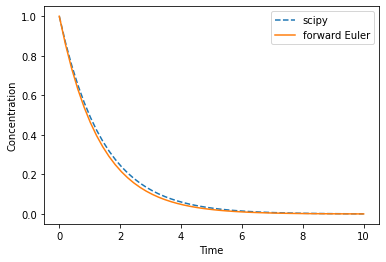

In [48]:
# Parameters
k = 0.7
times = np.linspace(0,10,50)

# A one-compartment PK model is basically an ODE for an exponential decay curve
def onecomp(y, t, k):
    """A one-compartment PK model, aka simple exponential decay
    In
    y: y-axis value
    t: x-axis value
    k: gradient parameter
    
    Out: gradient at the given point
    """
    dydt = -k * y
    return dydt

# You can solve ODEs with the Forward Euler method
def ForwardEuler(func, k, y0, times):
    """Numerically calculate an ODE (forward Euler technique)
    In
    func: function giving the derivative
    k: parameters the function requires as input
    y0: y at t=0
    times: array of times at which to calculate y
    
    Out: array of y values at corresponding points in times
    """
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)

    return y_solution

# You can also solve ODEs with scipy.integrate.odeint
def simulate(func, parameters, y0, times):
    """Numerically calculate an ODE
    In
    func: function giving the derivative
    parameters: parameters the function requires as input
    y0: y at t=0
    times: array of times at which to calculate y
    
    Out: array of y values at corresponding points in times
    """
    l = scipy.integrate.odeint(func, y0, times, (parameters,)) # returns a list of lists
    flatlist = [item for sublist in l for item in sublist] # to single list of 'y's
    return flatlist

# This is what the system output looks like. We don't actually know these values
actual_values_euler = ForwardEuler(onecomp, k, 1, times)
actual_values = simulate(onecomp, k, 1, times)

# Plot the model results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, actual_values, '--', label='scipy')
plt.plot(times, actual_values_euler, label='forward Euler')
plt.legend()
plt.show()

Without prior knowledge, we can make a guess at a model type that would give this kind of data, but we don't know what the parameters of the model are. We usually call these parameters theta ($\theta$) and in this single-compartment case the only parameter is k.

While we can estimate concentration (y(t)) at a given time (t) numerically by plotting from y(0), we have to guess a value of k. **We are trying to find the true value of k**.

You could measure from the system we're modelling, and you would get measurements with some measurement error, which we're modelling as gaussian noise below.

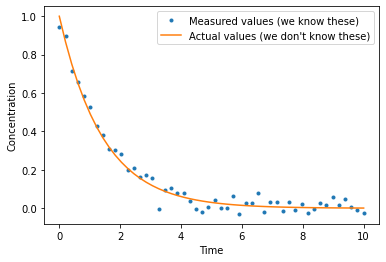

In [50]:
# Make noisy data that we're inferring from. noisy_data is known to us.
noise = np.random.normal(0, 0.03, len(actual_values))
noisy_data = actual_values + noise
plt.figure()
plt.plot(times, noisy_data, '.', label='Measured values (we know these)')
plt.plot(times, actual_values, label='Actual values (we don\'t know these)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

We're trying to find which value of $k$ makes our model output the closest to the real system output, assuming that the input dose for each is the same. To do this we define a function, `scalar_to_minimise`, whose output reduced in size, the closer model output is to measured system output.

In [51]:
# So what do we want to minimise?
def sumofsquares(y_model, y_data):
    """Gives the sum of the square of all errors between model and experimental data.
    In
    y_model: list of output values from model
    y_data: list of experimental (i.e. noisy) values
    
    Out: the sum of square error
    """
    sq_error = []
    for t in range(len(y_model)):
        sq_error.append((y_data[t] - y_model[t])**2)
    
    return sum(sq_error)

In [59]:
# Optimise it with scipy
def scalar_to_minimise(parameters):
    """For a one compartment model & sum of squares this is what's minimised"""
    y_model = simulate(onecomp, parameters, 1, times)
    y_data = noisy_data
    return sumofsquares(y_model, y_data) / len(y_model)

start_params = 11
result = scipy.optimize.minimize_scalar(scalar_to_minimise)
print('Calculated k: \t'+str(result.x))
print('Real k: \t'+str(k))

Calculated k: 	0.6813939360639867
Real k: 	0.7


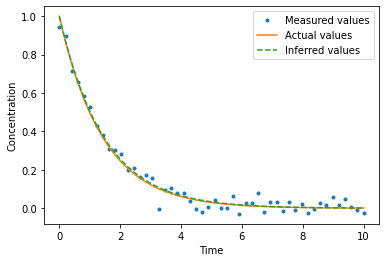

In [56]:
# What does that look like?
recon_model = simulate(onecomp, result.x, 1, times)
plt.figure()
plt.plot(times, noisy_data, '.', label='Measured values')
plt.plot(times, actual_values, label='Actual values')
plt.plot(times, recon_model, '--', label='Inferred values')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

## Using Pints
As you can see, our estimator estimates $k$ pretty well simply based on minimising the output of `scalar_to_minimise`. So how would we do what we've done above with Pints? Well, it's actually both easier to code and faster to calculate.

Custom calculation result: 	0.6813939360639867
Pints calculation result: 	0.6361384417836727


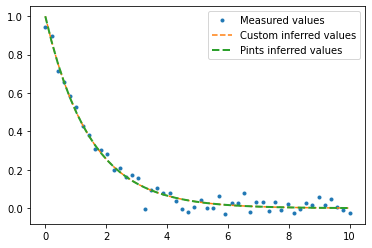

In [69]:
# Need to make the model into a Pints one
class PintsOneComp(pints.ForwardModel):
    def n_parameters(self):
        return 1
    def simulate(self, parameter, times):
        return ForwardEuler(onecomp, parameter, 1, times)
    
problem = pints.SingleOutputProblem(PintsOneComp(), times, noisy_data)
error_measure = pints.SumOfSquaresError(problem)
optimisation = pints.OptimisationController(error_measure, [1], method=pints.XNES)
optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()

# How does it look?
print('Custom calculation result: \t'+str(result.x))
print('Pints calculation result: \t'+str(parameters[0]))
plt.figure()
plt.plot(times, noisy_data, '.', label='Measured values')
plt.plot(times, recon_model, '--', label='Custom inferred values')
plt.plot(times, pintsmodel.simulate(parameters, times), '--', lw=2, label='Pints inferred values')
plt.legend()
plt.show()

# Bayesian sampling <a class="anchor" id="sampling"></a>

Optimisation gives us the most likely parameters, but sampling can give a probability distribution of different parameter values. The method we'll use here is Metropolis Hastings. In our exponential decay model, our only model parameter ($\theta$) is $k$ (the decay constant in equation 3 at the start of this tutorial).

Metropolis Hastings creates a series of potential values of $\theta$ by making random proposals for new $\theta$s and calculating the numerator of Bayes' rule (equation 2) for each one.

**Steps for Metropolis Hastings**
1. Start with an arbitrary $\theta$ (a k and a $\sigma$). Calculate prior x likelihood.
2. Move to a different $\theta$ (+/- an amount from a normal distribution with SD given by the 'covariate matrix'). Calculate prior x likelihood.
3. If new prior x likelihood is higher than old, keep it and add the new $\theta$ to a list. If not, keep it if rand(0->1) > (old/new). If neither of these work, move back to the old one and add that instead.
4. Repeat steps 2-3 for N steps. 
5. Count your list of $\theta$s into bins and draw a histogram. This approximates your posterior.

In [4]:
# This model stores all the model-related variables, for simplicity.

class OdeModel():
    
    def __init__(self, thetas, covariates, prior, likelihood, modeltype):
        self.thetas = thetas
        self.covariates = covariates
        self.modeltype = modeltype
        self.prior = prior
        self.likelihood = likelihood

In [5]:
# This gives a uniform prior P(theta) ~ U(0,10) 
# i.e. for any input between 0 & 10, it outputs 0.1, else 0.

def uniform_prior(theta):
    """Returns 0.1 if entire input list is between 0 & 10, else 0"""
    
    prior = []
    for key, param in theta.items():
        if param > 0 and param < 10:
            prior.append(0.1)
        else:
            prior.append(0)
            
    return min(prior)

In [70]:
# This calculates the likelihood P(y|theta)
# (probability that theta could give the output y_data)
# i.e. for input theta, the function returns:-
# 1/sqrt(2*pi*sigma) * exp(error^2/(2*sigma^2))

def likelihood_k(theta, y_data):
    """Returns the likelihood, P(theta|y)"""
    k = theta['k']
    sigma = 0.03
    pdf = []
    y_model = ForwardEuler(onecomp, k, 1, times)
    other_bit = 1/sqrt(2*math.pi*sigma**2)
    for t in range(len(y_data)): # this loop gives a normally distributed pdf
        square_error = (y_data[t] - y_model[t])**2
        exponential = math.exp(-square_error/(2*sigma**2))
        pdf.append(exponential*other_bit)
    
    return np.prod(pdf)

In [17]:
# This does steps 2 & 3 in the instructions above.
# It takes the model, the current theta value, and measured data
# It returns an accepted theta value.
# This is proposed_theta if accepted, else theta

def propose_new_theta(model, y_data, theta):
    """Randomly proposes a new theta and decides whether to accept or not
    In
    model: instance of OdeModel class
    y_data: list with experimental data
    theta: parameters, in a list
    
    Out: new parameters, either the same (if proposed not accepted) or different
    """

    numerator = model.prior(theta) * model.likelihood(theta, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = {}
    for key, value in theta.items():
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = model.prior(proposed_theta) * model.likelihood(proposed_theta, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta
    if proposed_numerator == 0:
        model.log['zero'] += 1
        pass
    elif proposed_numerator > numerator:
        theta = proposed_theta
        numerator = proposed_numerator
        model.log['large'] += 1
    elif np.random.rand() < proposed_numerator/numerator:
        model.log['frac'] += 1
        model.log['allfracs'].append(proposed_numerator/numerator)
        theta = proposed_theta
        numerator = proposed_numerator
    else:
        model.log['allfracs'].append(proposed_numerator/numerator)
    return theta



In [8]:
# This just runs propose_new_theta repeatedly

def metropolis_singlethread(model, y_data, threadnum, max_iters):
    iters = 0
    
    while iters < max_iters:
        theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
        model.thetas[threadnum].append(theta)
        iters = iters + 1

In [9]:
def metropolishastings(model, y_data, blocksize, number_of_blocks):
    n = 0
    while n < number_of_blocks:
        for threadnum, thetas_onelot in enumerate(model.thetas):
            metropolis_singlethread(model, y_data, threadnum, blocksize)
        n = n+1

Let's see this work. First, let's see what the likelihood is when we fix the measured data and take a variety of different proposed $k$ parameters.

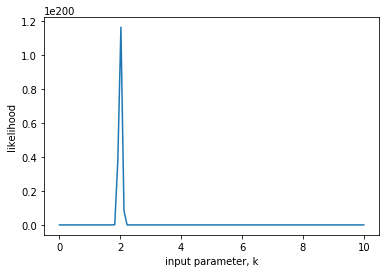

In [14]:
ks = np.linspace(0,10,100)
likelihoods = []
for k in ks:
    likelihoods.append(likelihood_k({'k':k}, noisy_data))

plt.figure()
plt.plot(ks, likelihoods)
plt.xlabel('input parameter, k')
plt.ylabel('likelihood')
plt.show()

In [30]:
# Run the metropolis hastings algorithm

thetas_k = [[{'k':5}], [{'k':3}], [{'k':1}]] # Three initial guesses for k
covariates_k = {'k':0.05} # Step size (SD of normal distribution for choosing next proposed theta)
model = OdeModel(thetas_k, covariates_k, uniform_prior, likelihood_k, onecomp)
metropolishastings(model, noisy_data, 10, 100)

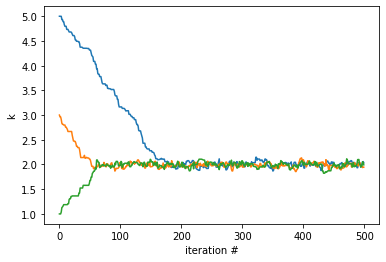

In [33]:
# This is how k looks (from all start-points) as the algorithm progresses

plt.figure()
for n in range(len(model.thetas)):
    ks_list= [theta['k'] for theta in model.thetas[n]]
    plt.plot(ks_list[:500]) # only first 500
plt.xlabel('iteration #')
plt.ylabel('k')
plt.show()

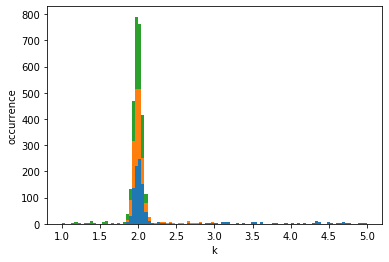

In [38]:
# Here are the occurrences of all k estimates throughout the algorithm

all_ks = []
for n in range(len(model.thetas)):
    ks_list = [theta['k'] for theta in model.thetas[n]]
    all_ks.append(ks_list)

plt.figure()
plt.hist(all_ks, bins=100, stacked=True)
plt.xlabel('k')
plt.ylabel('occurrence')
plt.show()

## Using Pints
Now let's try the same thing, but using Pints!  
Once again, it's much easier to type and quicker to run than our manual method above.

In [39]:
import pints

In [52]:
# Next, sampling.
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, sigma=0.05)
startpoints = [[1],[3],[5]]
mcmc = pints.MCMCController(log_likelihood, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(2000)
mcmc.set_log_to_screen(False)
samples = mcmc.run()

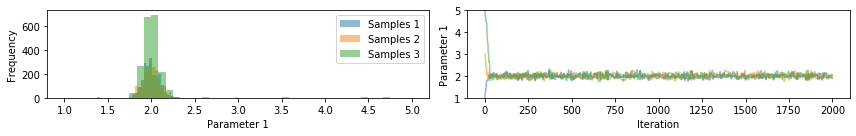

In [53]:
# Use a diagnostic plot to check if the chains have converged
import pints.plot
pints.plot.trace(samples)
plt.show()

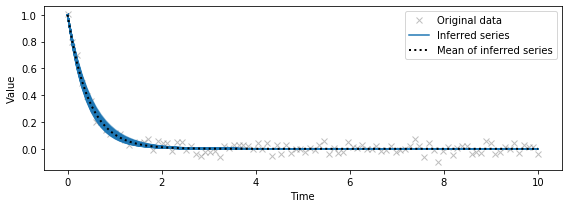

In [54]:
# Plot several predictions that are all likely sources of the experimental data
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.show()